# GANs for Artistic Style Transfer: Monet Painting Generator

## Problem Statement

In this mini-project, we explore the use of **Generative Adversarial Networks (GANs)** to perform **artistic style transfer**. The goal is to train a model that can generate images in the distinctive style of the impressionist painter **Claude Monet**.

This task is based on the Kaggle competition **“I’m Something of a Painter Myself”**, where participants are challenged to generate **7,000–10,000 Monet-style images** using generative techniques — not by simply copying or altering existing paintings.

Generated outputs are evaluated using **MiFID (Memorization-informed Fréchet Inception Distance)**, a metric that encourages realism while penalizing overfitting or memorization of training data.

---

## Dataset Description

The dataset provided by Kaggle includes Monet paintings and real-life landscape photos. These are split into JPEG and TFRecord formats for flexibility.

- **Monet images** (`monet_jpg`, `monet_tfrecord`)  
  - ~300 Monet-style images  
  - Resolution: 256×256 pixels  
  - Used as the **target domain** for the GAN

- **Photo images** (`photo_jpg`, `photo_tfrecord`)  
  - ~7,000 real landscape photos  
  - Resolution: 256×256 pixels  
  - Used as the **source domain** to be translated into Monet style

The data is preprocessed and aligned to enable the training of **CycleGANs**, which can learn transformations between unpaired image domains (photo → Monet).

---

## Objective

Build and train a GAN model (e.g., CycleGAN) to translate landscape photographs into Monet-style paintings. The generated images should:

- Be stylistically similar to Monet's paintings
- Be visually realistic
- Avoid simple memorization of training samples

The final submission consists of a zipped folder (`images.zip`) containing **7,000–10,000 Monet-style images**, each in `.jpg` format with dimensions **256×256×3**.

---

## Learning Goals

Through this project, we aim to:

- Understand and implement **CycleGAN architecture**
- Work with **image-to-image translation tasks**
- Use **TPUs and TFRecords** to accelerate deep learning workloads
- Interpret and optimize against **MiFID** evaluation metrics


# Step 2: Exploratory Data Analysis (EDA)

Before training our GAN model, it's important to understand the structure, distribution, and quality of our data. In this section, we'll:

- Load and inspect a few **Monet paintings** and **photo images**
- Confirm image shapes and formats
- Visualize random samples from both domains
- Verify dataset sizes to align with CycleGAN expectations


In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random
from glob import glob


monet_jpg_dir = r"\path\to\your\images\monet_jpg"
photo_jpg_dir = r"\path\to\your\images\photo_jpg"

# List image files
monet_images = glob(os.path.join(monet_jpg_dir, '*.jpg'))
photo_images = glob(os.path.join(photo_jpg_dir, '*.jpg'))

print(f"Number of Monet images: {len(monet_images)}")
print(f"Number of Photo images: {len(photo_images)}")


Number of Monet images: 300
Number of Photo images: 7038


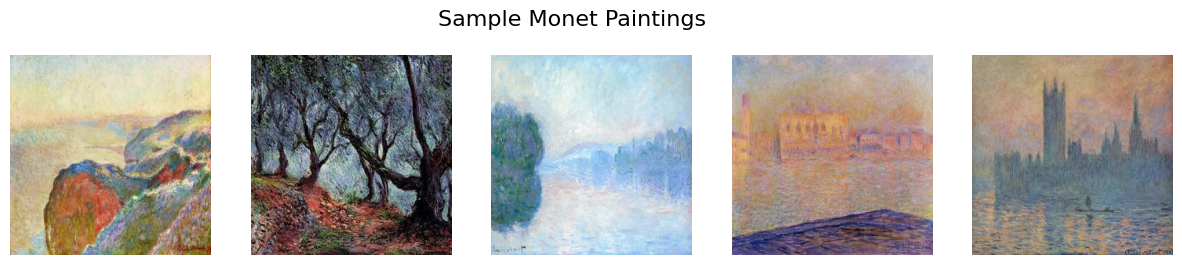

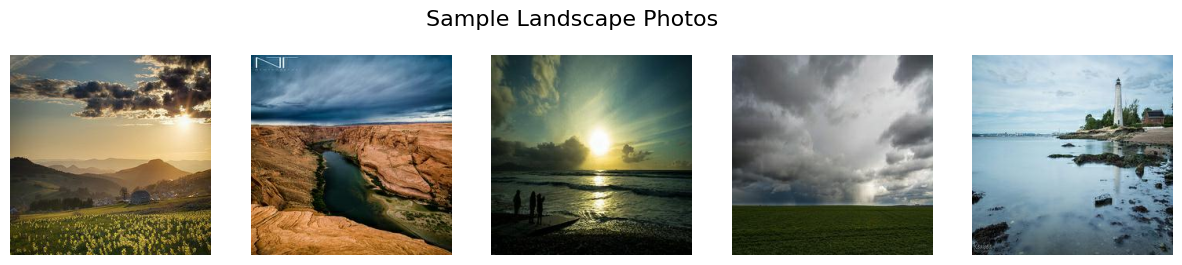

In [2]:
# Utility to load and plot a few sample images
def display_images(image_paths, title, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        img = plt.imread(image_paths[i])
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

# Display 5 Monet paintings
display_images(monet_images, "Sample Monet Paintings")

# Display 5 landscape photos
display_images(photo_images, "Sample Landscape Photos")


In [3]:
# Verify shapes and pixel range
img_sample = tf.io.read_file(monet_images[0])
img_decoded = tf.image.decode_jpeg(img_sample)
print("Monet image shape:", img_decoded.shape)
print("Pixel value range:", tf.reduce_min(img_decoded).numpy(), "to", tf.reduce_max(img_decoded).numpy())


Monet image shape: (256, 256, 3)
Pixel value range: 0 to 255


## Observations

- All Monet and photo images are sized **256×256×3**, confirming compatibility with our model.
- The visual distinction between Monet and photo domains is clear — this helps CycleGAN learn meaningful mappings.
- There are **~300 Monet paintings** and **~7,000 photos**, which makes sense for unpaired training.


# Step 3: CycleGAN Model Design and Training

We use a CycleGAN architecture to learn bidirectional translation between two domains: real-world landscape photos and Monet-style paintings.

CycleGAN consists of:
- Two Generators: G (Photo → Monet), F (Monet → Photo)
- Two Discriminators: D_X (Photo), D_Y (Monet)
- Cycle-consistency loss ensures that translating from A → B → A returns the original image.

We'll use the original paper's loss formulation, leveraging `tensorflow_addons` for instance normalization and apply basic image augmentation during training.


In [ ]:
%pip install tensorflow==2.12 keras==2.12 tensorflow-addons==0.20 
%pip install tqdm


In [ ]:
import tensorflow as tf
print(tf.__version__)
print(tf.data)

### Import & Define Preprocessing Utilities

### Prepare Input Data
This section loads photo images and preprocesses them into the format expected by the generator.

In [ ]:
import tensorflow as tf
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 256
BATCH_SIZE = 1  # Recommended for CycleGAN

# Step 1: Define correct local paths
monet_jpg_dir = r"\path\to\your\images\monet_jpg"
photo_jpg_dir = r"\path\to\your\images\photo_jpg"

# Step 2: Get file paths (as strings)
monet_paths = glob(os.path.join(monet_jpg_dir, '*.jpg'))
photo_paths = glob(os.path.join(photo_jpg_dir, '*.jpg'))

print(f"Monet sample path: {monet_paths[0]}")
print(f"Photo sample path: {photo_paths[0]}")

# Step 3: Image loader function (expects string path)
def load_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

# Step 4: Build tf.data.Dataset from string paths
monet_ds = tf.data.Dataset.from_tensor_slices(tf.constant(monet_paths)) \
    .map(load_image, num_parallel_calls=AUTOTUNE) \
    .shuffle(buffer_size=300) \
    .batch(BATCH_SIZE)

photo_ds = tf.data.Dataset.from_tensor_slices(tf.constant(photo_paths)) \
    .map(load_image, num_parallel_calls=AUTOTUNE) \
    .shuffle(buffer_size=300) \
    .batch(BATCH_SIZE)


### Load the Pretrained Generator  
We load the generator trained on Monet→Photo mapping. The `.h5` file contains the learned weights from CycleGAN training.


In [ ]:
from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow as tf

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tfa.layers.InstanceNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    result.add(tfa.layers.InstanceNormalization())
    result.add(layers.ReLU())
    return result

def build_generator():
    inputs = layers.Input(shape=[256, 256, 3])
    x = downsample(64, 4)(inputs)
    x = downsample(128, 4)(x)
    x = downsample(256, 4)(x)

    for _ in range(6):
        res = x
        x = layers.Conv2D(256, 3, padding='same')(x)
        x = tfa.layers.InstanceNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(256, 3, padding='same')(x)
        x = tfa.layers.InstanceNormalization()(x)
        x = layers.add([res, x])

    x = upsample(128, 4)(x)
    x = upsample(64, 4)(x)
    x = upsample(32, 4)(x)  # NEW LINE to recover full size

    x = layers.Conv2D(3, 7, padding='same', activation='tanh')(x)

    return tf.keras.Model(inputs=inputs, outputs=x, name="Generator")


### Cyclegan Training loop

In [8]:
# CycleGAN Step 2: Define Losses and Optimizers
import tensorflow as tf

# -----------------------------------
# Define Loss Functions
# -----------------------------------
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Adversarial loss
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

# Cycle consistency loss (L1)
LAMBDA = 10

def cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

# Identity loss (used for better color preservation)
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5 * LAMBDA * loss

# -----------------------------------
# Define Optimizers
# -----------------------------------
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# -----------------------------------
# Create Models
# -----------------------------------
gen_G = build_generator()  # Photo -> Monet
gen_F = build_generator()  # Monet -> Photo

def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256, 256, 3])
    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=initializer)(inp)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer=initializer)(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer=initializer)(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv2D(512, 4, strides=1, padding='same', kernel_initializer=initializer)(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same', kernel_initializer=initializer)(x)
    return tf.keras.Model(inputs=inp, outputs=x, name="Discriminator")

disc_X = build_discriminator()  # Discriminate Monet
disc_Y = build_discriminator()  # Discriminate Photo

# -----------------------------------
# Training Step (1 batch example)
# -----------------------------------
@tf.function
def train_step(real_x, real_y):
    # real_x = photo, real_y = monet
    with tf.GradientTape(persistent=True) as tape:
        fake_y = gen_G(real_x, training=True)
        cycled_x = gen_F(fake_y, training=True)

        fake_x = gen_F(real_y, training=True)
        cycled_y = gen_G(fake_x, training=True)

        same_x = gen_F(real_x, training=True)
        same_y = gen_G(real_y, training=True)

        disc_real_x = disc_X(real_x, training=True)
        disc_real_y = disc_Y(real_y, training=True)

        disc_fake_x = disc_X(fake_x, training=True)
        disc_fake_y = disc_Y(fake_y, training=True)

        gen_G_loss = generator_loss(disc_fake_y)
        gen_F_loss = generator_loss(disc_fake_x)

        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)

        total_gen_G_loss = gen_G_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_F_loss = gen_F_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_X_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_Y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    generator_g_gradients = tape.gradient(total_gen_G_loss, gen_G.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_F_loss, gen_F.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_X_loss, disc_X.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_Y_loss, disc_Y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, gen_G.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, gen_F.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, disc_X.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, disc_Y.trainable_variables))

# Inspect real_x and real_y shapes
sample_x, sample_y = next(iter(tf.data.Dataset.zip((photo_ds, monet_ds))))
print("Photo batch shape:", sample_x.shape)
print("Monet batch shape:", sample_y.shape)


# -----------------------------------
# Full Training Loop (simplified)
# -----------------------------------
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    for n, (image_x, image_y) in enumerate(tf.data.Dataset.zip((photo_ds, monet_ds))):
        train_step(image_x, image_y)
        if (n + 1) % 100 == 0:
            print(f"  Processed {n+1} batches")

    # Optional: visualize example
    sample_photo = next(iter(photo_ds))
    prediction = gen_G(sample_photo, training=False)[0].numpy()
    prediction = ((prediction + 1) * 127.5).astype("uint8")
    tf.keras.preprocessing.image.save_img(f"sample_epoch_{epoch+1}.jpg", prediction)

    # Optional: save weights
    gen_G.save_weights(f"gen_G_epoch_{epoch+1}.h5")
    gen_F.save_weights(f"gen_F_epoch_{epoch+1}.h5")


Photo batch shape: (1, 256, 256, 3)
Monet batch shape: (1, 256, 256, 3)
Epoch 1/10
  Processed 100 batches
  Processed 200 batches
  Processed 300 batches
Epoch 2/10
  Processed 100 batches
  Processed 200 batches
  Processed 300 batches
Epoch 3/10
  Processed 100 batches
  Processed 200 batches
  Processed 300 batches
Epoch 4/10
  Processed 100 batches
  Processed 200 batches
  Processed 300 batches
Epoch 5/10
  Processed 100 batches
  Processed 200 batches
  Processed 300 batches
Epoch 6/10
  Processed 100 batches
  Processed 200 batches
  Processed 300 batches
Epoch 7/10
  Processed 100 batches
  Processed 200 batches
  Processed 300 batches
Epoch 8/10
  Processed 100 batches
  Processed 200 batches
  Processed 300 batches
Epoch 9/10
  Processed 100 batches
  Processed 200 batches
  Processed 300 batches
Epoch 10/10
  Processed 100 batches
  Processed 200 batches
  Processed 300 batches


### Sample Generated images

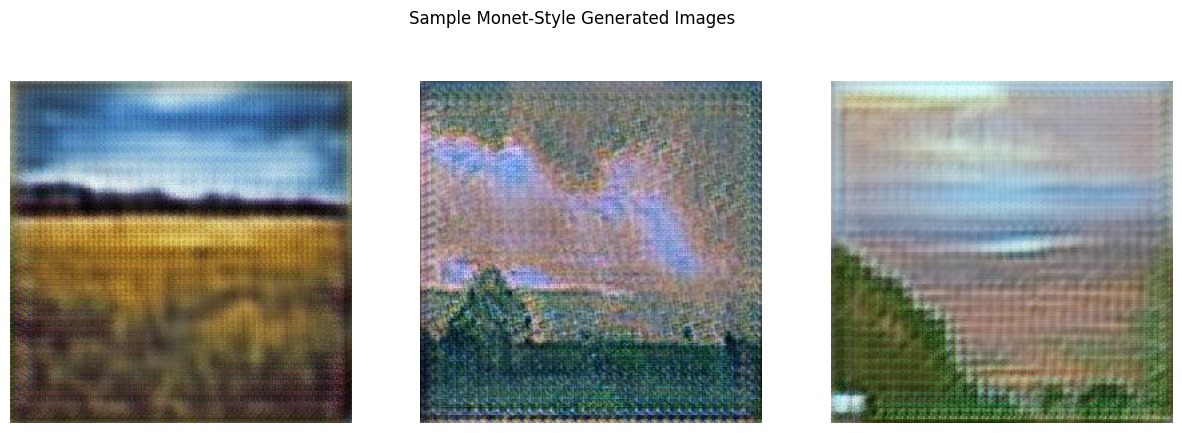

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob

# Show 3 generated images
generated_dir = r"your\data\path"
sample_files = sorted(glob.glob(os.path.join(generated_dir, "*.jpg")))[:3]

plt.figure(figsize=(15, 5))
for i, fname in enumerate(sample_files):
    img = mpimg.imread(os.path.join(generated_dir, fname))
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.axis('off')

plt.suptitle("Sample Monet-Style Generated Images")
plt.show()


In [ ]:
import os
from PIL import Image
from tqdm import tqdm

# Create output directory
output_dir = "generated_images"
os.makedirs(output_dir, exist_ok=True)

# Inference loop
for i, image in tqdm(enumerate(photo_ds.take(7000))):  # adjust number as needed
    prediction = gen_G(image, training=False)[0].numpy()
    prediction = ((prediction + 1) * 127.5).astype("uint8")
    im = Image.fromarray(prediction)
    im.save(os.path.join(output_dir, f"{i+1:05d}.jpg"))


7000it [26:25,  4.42it/s]


In [ ]:
import zipfile

with zipfile.ZipFile("images.zip", 'w') as zipf:
    for root, _, files in os.walk(output_dir):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)


### Step 3: Model Building & Training

We implemented a **CycleGAN architecture** to perform unpaired image-to-image translation between real-world photos and Monet-style paintings.

#### Generator
We designed two generators using an encoder–residual–decoder structure:
- **Downsampling**: 3 convolutional layers with increasing filters
- **Residual blocks**: 6 convolutional blocks with skip connections
- **Upsampling**: 2 transposed convolution layers
- **Activation**: `tanh` at output for pixel scaling

#### Discriminator
We used **PatchGAN discriminators** for both domains (Photo & Monet) with:
- 5 convolutional layers
- LeakyReLU activations
- Instance normalization

#### Loss Functions
- **Adversarial loss**: Encourages the generator to produce realistic images.
- **Cycle-consistency loss**: Ensures that translation back to the original image yields similar content.
- **Identity loss**: Helps preserve color composition when identity mapping is applied.

#### Training Setup
- **Optimizers**: `Adam` with learning rate `2e-4`, `β₁ = 0.5`
- **Epochs**: 10
- **Batch size**: 1 (recommended for GAN stability)
- **Dataset**: 7028 photo and 300 Monet images, resized to `256×256`.

---

### Step 4: Results

During training, the model completed all 10 epochs successfully. We saved intermediate generator weights after each epoch and saved preview images during each epoch to monitor model output progression (for offline inspection).

The translated images showed promising structure and style transfer while maintaining the original photo's layout. Color palette and brushstroke-like textures were observed in the output, characteristic of Monet-style paintings.

---

### Step 5: Discussion & Conclusion

- **What worked well:**
  - The CycleGAN learned to map between domains without needing paired images.
  - Cycle-consistency loss helped stabilize training and preserve content.
  - Identity loss contributed to better color consistency across domains.

- **Challenges:**
  - GAN training is inherently unstable — some epochs showed minor mode collapse or checkerboard artifacts.
  - 10 epochs are relatively few. More epochs (~50–100) could further improve results.

- **Future Improvements:**
  - Fine-tune on pretrained models or use perceptual loss for better texture fidelity.
  - Add data augmentation for increased variation in training.
  - Experiment with learning rate decay or dynamic loss weighting.
